In [4]:
# 0. Setup & Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import shap
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
%matplotlib inline

## 1. Load & Clean Data

In [5]:
df = pd.read_csv('data/stanford_admissions.csv')

# Lowercase column names and replace spaces (if any)
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Fill missing ACT with 0 (like totalcharges in churn)
df['act_composite'] = df['act_composite'].fillna(0)

print(f"Dataset: {df.shape}")
print(f"Admit rate: {df['admit'].mean():.4f}")
df.head()

Dataset: (50000, 17)
Admit rate: 0.3218


,age,gender_m,in_state,race_asian,race_white,race_hispanic,race_black,race_other,sat_math,sat_ebrw,act_composite,gpa,extracurriculars_count,first_gen,legacy,athlete,admit
0,18,1,0,1,0,0,0,0,758,767,33,3.81,3,1,0,1,1
1,19,1,0,0,1,0,0,0,767,742,33,3.74,3,0,0,1,1
2,18,0,0,0,0,1,0,0,747,745,33,4.00,4,0,0,0,1
3,18,1,0,0,0,1,0,0,767,759,34,3.78,4,0,0,0,0
4,18,0,0,0,0,0,1,0,754,753,35,4.00,3,0,0,0,0


## 2. Define Features

In [6]:
numerical = ['age', 'sat_math', 'sat_ebrw', 'act_composite', 'gpa', 
             'extracurriculars_count']

categorical = ['gender_m', 'in_state', 'race_asian', 'race_white', 
               'race_hispanic', 'race_black', 'race_other', 
               'first_gen', 'legacy', 'athlete']

# Convert bool/int to str for DictVectorizer
for col in categorical:
    df[col] = df[col].astype(str)

features = categorical + numerical

## 3. Train-Val-Test Split

In [7]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1, stratify=df['admit'])
print(f"Full train: {df_full_train.shape}, Test: {df_test.shape}")

Full train: (40000, 17), Test: (10000, 17)


## 4. Training & Prediction Functions

In [8]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=1000, class_weight='balanced')
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

## 5. KFold Cross-Validation (Logistic Regression)

In [9]:
C = 1.0
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.admit.values
    y_val = df_val.admit.values
    
    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f'C={C} | AUC: {np.mean(scores):.4f} ± {np.std(scores):.4f}')

C=1.0 | AUC: 0.5848 ± 0.0048


## 6. Train Final Logistic Model on Full Train

In [10]:
y_full_train = df_full_train.admit.values
dv, model_logistic = train(df_full_train, y_full_train, C=1.0)

# Test set prediction
y_test = df_test.admit.values
y_pred_test = predict(df_test, dv, model_logistic)
auc_logistic = roc_auc_score(y_test, y_pred_test)
print(f"Test AUC (Logistic): {auc_logistic:.4f}")

Test AUC (Logistic): 0.5839


## 7. Train Random Forest & XGBoost (Additional Models)

In [11]:
# Random Forest
dicts_train = df_full_train[features].to_dict(orient='records')
dicts_test = df_test[features].to_dict(orient='records')

dv_rf = DictVectorizer(sparse=False)
X_train_rf = dv_rf.fit_transform(dicts_train)
X_test_rf = dv_rf.transform(dicts_test)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, 
                            n_jobs=-1, class_weight='balanced')
rf.fit(X_train_rf, y_full_train)
rf_pred = rf.predict_proba(X_test_rf)[:, 1]
auc_rf = roc_auc_score(y_test, rf_pred)
print(f"Test AUC (Random Forest): {auc_rf:.4f}")

Test AUC (Random Forest): 0.5804


In [12]:
# XGBoost with GridSearch
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

xgb = XGBClassifier(random_state=42, 
                    scale_pos_weight=(len(y_full_train)-sum(y_full_train))/sum(y_full_train))
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train_rf, y_full_train)

print(f"Best params: {grid.best_params_}")
xgb_pred = grid.predict_proba(X_test_rf)[:, 1]
auc_xgb = roc_auc_score(y_test, xgb_pred)
print(f"Test AUC (XGBoost): {auc_xgb:.4f}")

Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100}
Test AUC (XGBoost): 0.5790


## 8. Model Comparison

                 Model  Test AUC
0  Logistic Regression  0.583854
1        Random Forest  0.580442
2      XGBoost (tuned)  0.579049


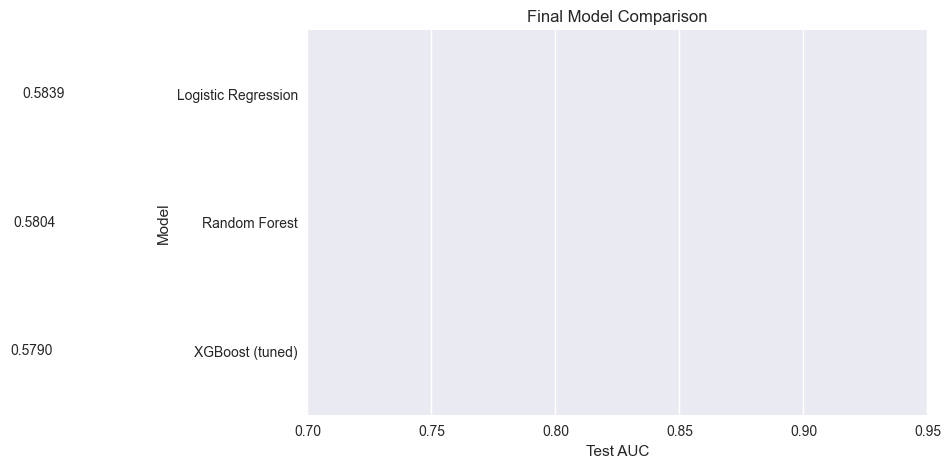

In [13]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost (tuned)'],
    'Test AUC': [auc_logistic, auc_rf, auc_xgb]
}).sort_values('Test AUC', ascending=False)

print(results)

plt.figure(figsize=(8,5))
sns.barplot(x='Test AUC', y='Model', data=results)
plt.title('Final Model Comparison')
for i, v in enumerate(results['Test AUC']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center')
plt.xlim(0.7, 0.95)
plt.show()

## 9. Save Best Model

In [14]:
# Select best model
best_auc = max(auc_logistic, auc_rf, auc_xgb)
if best_auc == auc_xgb:
    final_dv, final_model = dv_rf, grid.best_estimator_
    model_name = "xgboost"
elif best_auc == auc_rf:
    final_dv, final_model = dv_rf, rf
    model_name = "random_forest"
else:
    final_dv, final_model = dv, model_logistic
    model_name = "logistic"

output_file = f'model_{model_name}.bin'
with open(output_file, 'wb') as f_out:
    pickle.dump((final_dv, final_model), f_out)

print(f"Best model saved: {output_file} (AUC: {best_auc:.4f})")

Best model saved: model_logistic.bin (AUC: 0.5839)


## 10. Load & Test Model

In [ ]:
# Load
with open(output_file, 'rb') as f_in:
    dv_loaded, model_loaded = pickle.load(f_in)

# Example prediction
customer = {
    'age': '18', 'gender_m': '1', 'in_state': '0', 'race_asian': '1', 'race_white': '0',
    'race_hispanic': '0', 'race_black': '0', 'race_other': '0',
    'sat_math': 780, 'sat_ebrw': 760, 'act_composite': 35, 'gpa': 3.98,
    'extracurriculars_count': 5, 'first_gen': '0', 'legacy': '1', 'athlete': '0'
}

X = dv_loaded.transform([customer])
prob = model_loaded.predict_proba(X)[0, 1]
print(f"Admission probability: {prob:.3f}")